In [1]:
from Model3 import RiverDeltaModel
import matplotlib.pyplot as plt
import networkx as nx
import warnings 
import copy
import matplotlib.lines as mlines

c:\Users\sjuul\anaconda3\envs\afstuderen2025\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.simplefilter("ignore")

model = RiverDeltaModel()

initial_model_state = copy.deepcopy(model) 
for j in range(300):
    model.step()

There are 0 agents unassigned!!
old debt is:  0


TypeError: print() got an unexpected keyword argument 'land_size'

In [ ]:
model_data = model.datacollector.get_model_vars_dataframe()
model_data

,Average_Livelihood
0,0.495302
1,0.571781
2,0.570801
3,0.573308
4,0.578237
5,0.582270
6,0.582468
7,0.581359
8,0.584906
9,0.585509


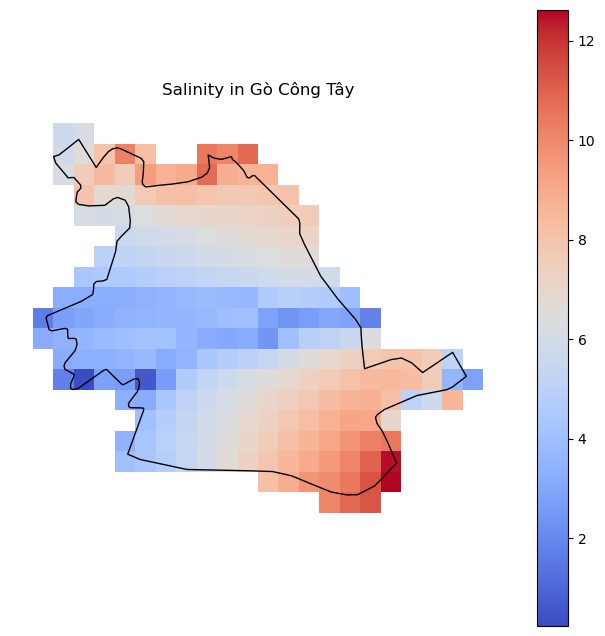

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
model.polygon_districts.boundary.plot(ax=ax, color='black', linewidth=1)
model.data_salinity.plot(ax=ax, column="Salinity", cmap="coolwarm", legend=True)
plt.title(f"Salinity in {model.district}")
plt.axis("off")
plt.show()

145
115


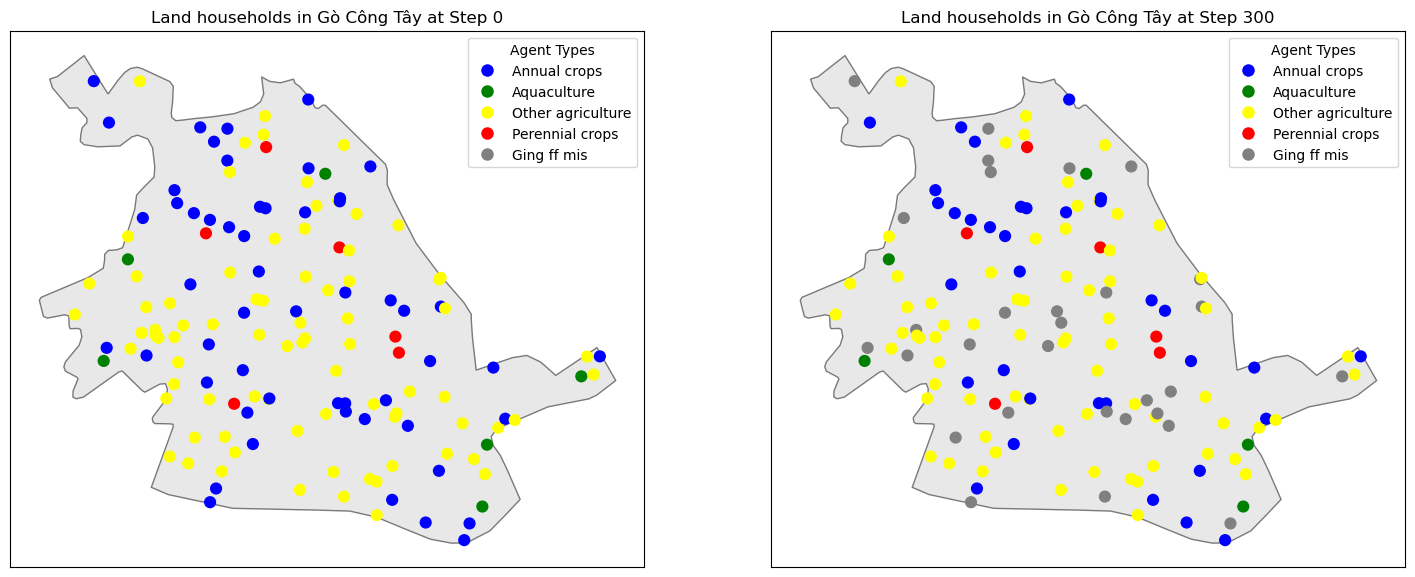

In [ ]:
from Model3 import Large_land_households, Middle_land_households, Small_land_households

def plot_network(ax, model):
    ax.clear()

    # Plot district map
    model.polygon_districts.plot(ax=ax, facecolor="lightgray", edgecolor="black", alpha=0.5)

    # Get node positions
    pos = nx.get_node_attributes(model.G, 'pos')

    # Map node_id to agent
    node_to_agent = {
        agent.node_id: agent
        for agent in model.agents
        if isinstance(agent, (Large_land_households, Middle_land_households, Small_land_households))
    }
    print(len(node_to_agent))
    # Prepare lists for nodes and their colors
    nodes_to_draw = []
    colors_to_draw = []

    for node_id in model.G.nodes():
        nodes_to_draw.append(node_id)
        agent = node_to_agent.get(node_id)
        if agent:
            if agent.crop_type == "Annual crops":
                colors_to_draw.append('blue')
            elif agent.crop_type == "Aquaculture":
                colors_to_draw.append('green')
            elif agent.crop_type == "Other agriculture":
                colors_to_draw.append('yellow')
            elif agent.crop_type == "Perennial crops":
                colors_to_draw.append('red')
            else:
                colors_to_draw.append("gray")  # unknown crop
        else:
            colors_to_draw.append("gray")  # migrated / no agent

    # Draw edges first (optional)
    #nx.draw_networkx_edges(model.G, pos, ax=ax, edge_color="gray")

    # Draw nodes with matching colors
    nx.draw_networkx_nodes(model.G, pos,
                           nodelist=nodes_to_draw,
                           node_color=colors_to_draw,
                           node_size=60,
                           ax=ax)

    # Add legend
    blue_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Annual crops')
    green_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='green', markersize=10, label='Aquaculture')
    yellow_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Other agriculture')
    red_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='red', markersize=10, label='Perennial crops')
    grey_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Ging ff mis')
    ax.legend(handles=[blue_patch, green_patch, yellow_patch, red_patch, grey_patch], loc='upper right', title='Agent Types')

    ax.set_title(f"Land households in {model.district} at Step {model.steps}", fontsize=12)

    # Call function above to plot the map
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 9))
plot_network(ax1, initial_model_state)
plot_network(ax2, model)
plt.show()
